**Deep Learning Homework 3 Question 1**

**Alireza Shokrani - 99106255**

In [ ]:
import torch
import copy
import matplotlib.pyplot as plt

from torch.utils.data import Subset, DataLoader
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

In [ ]:
plt.rc('image', cmap='gray')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


**Loading the Dataset**

In [ ]:
full_train_set = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor())

full_test_set = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 72239993.19it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# Choosing only two classes ('airplane': 0, 'automobile': 1)

train_indices = [i for i in range(len(full_train_set)) if full_train_set.targets[i] in [0, 1]]
test_indices = [i for i in range(len(full_test_set)) if full_test_set.targets[i] in [0, 1]]

train_set = Subset(full_train_set, train_indices)
test_set = Subset(full_test_set, test_indices)

**Loading the Model (RESNET-50)**

In [ ]:
myModel = resnet50(pretrained = True)
myModel.to(device)
print(myModel)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# creating the dataloaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
def test_model(model, test_loader, device):
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs.data, 1)

          # update totals
          total += labels.size(0)
          correct += (preds == labels).sum().item()

  print('Accuracy of the network on the {total} test images:  %.2f' % (100 * correct / total))

# Part 1

In [ ]:
# clone the original model for this part
model1 = copy.deepcopy(myModel)
model1.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
model1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# defining the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
# training phase
epoch_nums = 5
losses = []
accs = []
for epoch in range(epoch_nums):
    running_loss = 0.0
    total = 0
    correct = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)

        # update totals
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_set)
    epoch_acc = 100 * correct / total
    losses.append(epoch_loss)
    accs.append(epoch_acc)
    print('Epoch %d, loss: %f' % (epoch + 1, epoch_loss))
    print('Epoch %d, accuracy: %.2f' % (epoch + 1, epoch_acc))

print('Finished Training')

Epoch 1, loss: 0.002933
Epoch 1, accuracy: 92.93
Epoch 2, loss: 0.001210
Epoch 2, accuracy: 97.29
Epoch 3, loss: 0.000832
Epoch 3, accuracy: 98.12
Epoch 4, loss: 0.000847
Epoch 4, accuracy: 98.10
Epoch 5, loss: 0.000755
Epoch 5, accuracy: 98.37
Finished Training


Text(0, 0.5, 'Training Accuracy')

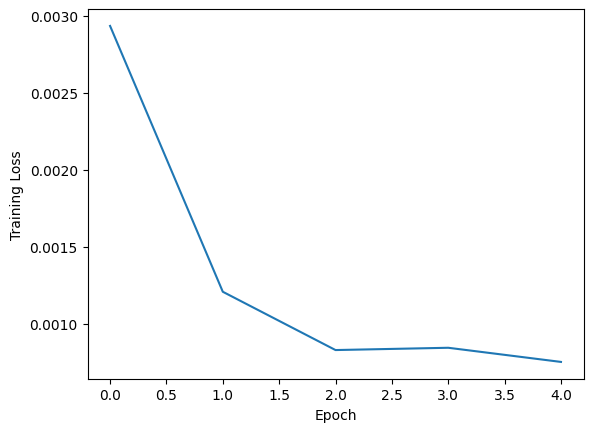

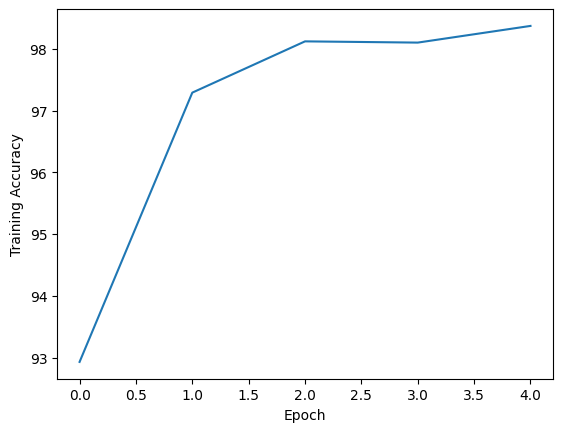

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.figure()
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

In [ ]:
# test phase
test_model(model1, test_loader, device)

Accuracy of the network on the {total} test images:  97.20


# Part 2

In [ ]:
# getting data of these two classes ('airplane': 0, 'automobile': 1)
airplane_images = []
automobile_images = []
for data, target in train_set:
    if target == 0:
        airplane_images.append(data)
    elif target == 1:
        automobile_images.append(data)

airplane_images = torch.stack(airplane_images)
automobile_images = torch.stack(automobile_images)


In [ ]:
def get_pos_neg(data, labels):
    random_airplane = airplane_images[torch.randperm(len(labels))]
    random_automobile = automobile_images[torch.randperm(len(labels))]

    # pos = torch.stack([random_airplane[i] if labels[i]==0 else random_automobile[i] for i in range(len(data))])
    # neg = torch.stack([random_airplane[i] if labels[i]==1 else random_automobile[i] for i in range(len(data))])
    pos = []
    neg = []
    for i in range(len(data)):
        if labels[i]==0:
            pos.append(random_airplane[i])
            neg.append(random_automobile[i])
        else:
            pos.append(random_automobile[i])
            neg.append(random_airplane[i])

    pos = torch.stack(pos)
    neg = torch.stack(neg)
    return pos, neg

In [ ]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        d_pos = (anchor - positive).pow(2).sum(1)
        d_neg = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(d_pos - d_neg + self.margin)
        return losses.mean()

In [ ]:
# clone the original model for this part
model2 = copy.deepcopy(myModel)
model2 = torch.nn.Sequential(*(list(model2.children())[:-1]))
model2.add_module('flatten', torch.nn.Flatten())

In [ ]:
# defining the loss function and optimizer
criterion = TripletLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)

In [ ]:
# feature extractor trainig phase
epoch_nums = 5
feature_losses = []
for epoch in range(epoch_nums):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pos_input, neg_input = get_pos_neg(inputs, labels)
        anch = model2(inputs)
        pos = model2(pos_input.to(device))
        neg = model2(neg_input.to(device))
        loss = criterion(anch, pos, neg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    feature_losses.append(epoch_loss)
    print('Epoch %d, loss: %f' % (epoch + 1, epoch_loss))

print('Finished Training')

Epoch 1, loss: 8.007596
Epoch 2, loss: 0.517227
Epoch 3, loss: 0.438050
Epoch 4, loss: 0.389761
Epoch 5, loss: 0.327659
Finished Training


Text(0, 0.5, 'Feature Extractor Training Loss')

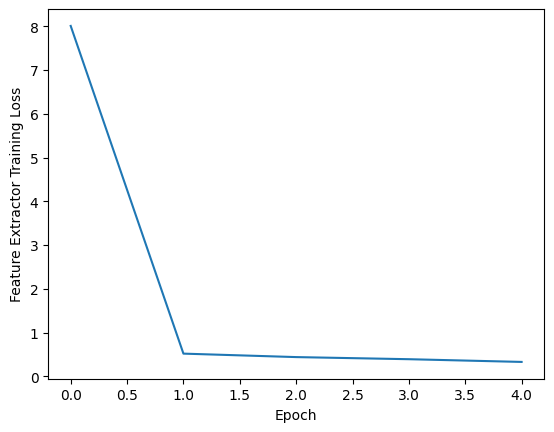

In [ ]:
plt.figure()
plt.plot(feature_losses)
plt.xlabel('Epoch')
plt.ylabel('Feature Extractor Training Loss')

In [ ]:
model2_final = copy.deepcopy(model2)
for param in model2_final.parameters():
  param.requires_grad = False

model2_final.add_module('fc', torch.nn.Linear(in_features=2048, out_features=2, bias=True))
model2_final.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# defining the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2_final.parameters(), lr=0.001)

In [ ]:
# fully-connected layer training phase
epoch_nums = 7
losses = []
accs = []
for epoch in range(epoch_nums):
    running_loss = 0.0
    total = 0
    correct = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model2_final(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)

        # update totals
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_set)
    epoch_acc = 100 * correct / total
    losses.append(epoch_loss)
    accs.append(epoch_acc)
    print('Epoch %d, loss: %f' % (epoch + 1, epoch_loss))
    print('Epoch %d, accuracy: %.2f' % (epoch + 1, epoch_acc))

print('Finished Training')

Epoch 1, loss: 0.010274
Epoch 1, accuracy: 73.09
Epoch 2, loss: 0.009052
Epoch 2, accuracy: 88.49
Epoch 3, loss: 0.008127
Epoch 3, accuracy: 88.58
Epoch 4, loss: 0.007466
Epoch 4, accuracy: 88.49
Epoch 5, loss: 0.006923
Epoch 5, accuracy: 88.69
Epoch 6, loss: 0.006517
Epoch 6, accuracy: 88.35
Epoch 7, loss: 0.006139
Epoch 7, accuracy: 88.81
Finished Training


Text(0, 0.5, 'Training Accuracy')

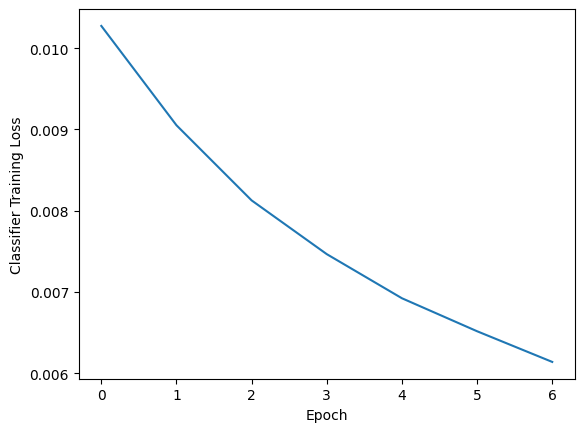

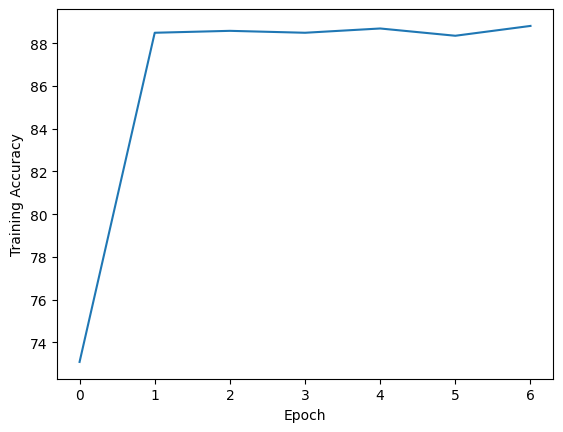

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Classifier Training Loss')
plt.figure()
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

In [ ]:
# test phase
test_model(model2_final, test_loader, device)

Accuracy of the network on the {total} test images:  87.55


# Part 3

In [ ]:
model3 = copy.deepcopy(myModel)
model3 = torch.nn.Sequential(*(list(model3.children())[:-1]))
model3.add_module('flatten', torch.nn.Flatten())
model3_fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
model3_fc.to(device)

Linear(in_features=2048, out_features=2, bias=True)

In [ ]:
# defining the loss function and optimizer
triplet_ctrn = TripletLoss()
bce_ctrn = torch.nn.CrossEntropyLoss()
params = list(model3.parameters()) + list(model3_fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)

In [ ]:
# feature extractor trainig phase
epoch_nums = 10
losses = []
accs = []
for epoch in range(epoch_nums):
    running_loss = 0.0
    total = 0
    correct = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pos_input, neg_input = get_pos_neg(inputs, labels)
        anch = model3(inputs)
        pos = model3(pos_input.to(device))
        neg = model3(neg_input.to(device))
        loss = triplet_ctrn(anch, pos, neg)

        outputs = model3_fc(anch)
        loss += bce_ctrn(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_set)
    epoch_acc = 100 * correct / total
    losses.append(epoch_loss)
    accs.append(epoch_acc)
    print('Epoch %d, loss: %f' % (epoch + 1, epoch_loss))
    print('Epoch %d, accuracy: %.2f' % (epoch + 1, epoch_acc))

print('Finished Training')

Epoch 1, loss: 0.158833
Epoch 1, accuracy: 72.45
Epoch 2, loss: 0.012865
Epoch 2, accuracy: 85.84
Epoch 3, loss: 0.010761
Epoch 3, accuracy: 87.13
Epoch 4, loss: 0.008114
Epoch 4, accuracy: 90.03
Epoch 5, loss: 0.007052
Epoch 5, accuracy: 91.35
Epoch 6, loss: 0.007001
Epoch 6, accuracy: 91.52
Epoch 7, loss: 0.005773
Epoch 7, accuracy: 92.78
Epoch 8, loss: 0.005269
Epoch 8, accuracy: 94.24
Epoch 9, loss: 0.009003
Epoch 9, accuracy: 89.45
Epoch 10, loss: 0.005624
Epoch 10, accuracy: 93.45
Finished Training


Text(0, 0.5, 'Training Accuracy')

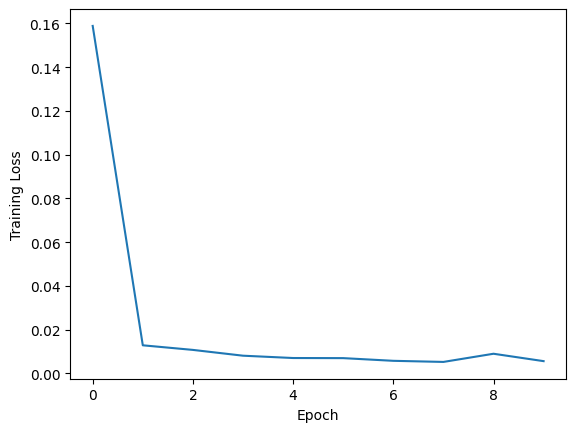

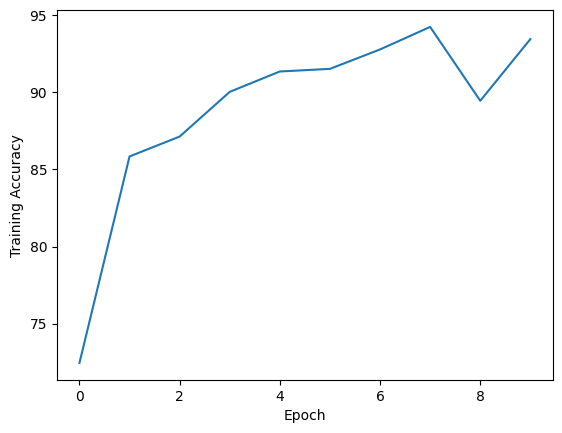

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.figure()
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

In [ ]:
# test phase
model3.add_module('fc', model3_fc)
test_model(model3, test_loader, device)

Accuracy of the network on the {total} test images:  91.70
